In [24]:
%pip install matplotlib numpy pandas scikit-learn seaborn opendatasets legacy-cgi keras tf-nightly tabulate

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import opendatasets as od
od.download('https://www.kaggle.com/datasets/shankarpriya2913/crop-and-soil-dataset')
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

Skipping, found downloaded files in ".\crop-and-soil-dataset" (use force=True to force download)


In [3]:
df = pd.read_csv('crop-and-soil-dataset/data_core.csv')
eval_metrics = [['Model','MAE','MSE','RMSE','R2'],0,0,0,0]

In [4]:
#categorical columns
categorical_cols = ['Soil Type', 'Crop Type','Fertilizer Name']

from sklearn.preprocessing import LabelEncoder
encoders = {}
for col in categorical_cols:
    enc = LabelEncoder()
    df[col] = enc.fit_transform(df[col])
    encoders[col] = enc  # store encoder for later

print("Mappings for Soil Type:", list(encoders['Soil Type'].classes_))
print("Mappings for Crop Type:", list(encoders['Crop Type'].classes_))

print(df.head())


Mappings for Soil Type: ['Black', 'Clayey', 'Loamy', 'Red', 'Sandy']
Mappings for Crop Type: ['Barley', 'Cotton', 'Ground Nuts', 'Maize', 'Millets', 'Oil seeds', 'Paddy', 'Pulses', 'Sugarcane', 'Tobacco', 'Wheat']
   Temparature  Humidity  Moisture  Soil Type  Crop Type  Nitrogen  Potassium  \
0         26.0      52.0      38.0          4          3        37          0   
1         29.0      52.0      45.0          2          8        12          0   
2         34.0      65.0      62.0          0          1         7          9   
3         32.0      62.0      34.0          3          9        22          0   
4         28.0      54.0      46.0          1          6        35          0   

   Phosphorous  Fertilizer Name  
0            0                6  
1           36                5  
2           30                1  
3           20                4  
4            0                6  


In [5]:
corr_matrix = df.corr(numeric_only = True)
print(corr_matrix)

                 Temparature  Humidity  Moisture  Soil Type  Crop Type  \
Temparature         1.000000  0.525594  0.067963   0.009544   0.006371   
Humidity            0.525594  1.000000  0.066713   0.005344   0.026676   
Moisture            0.067963  0.066713  1.000000   0.006529   0.000604   
Soil Type           0.009544  0.005344  0.006529   1.000000  -0.007889   
Crop Type           0.006371  0.026676  0.000604  -0.007889   1.000000   
Nitrogen           -0.028978 -0.042701 -0.085016   0.019426   0.005704   
Potassium          -0.031322  0.005695  0.023618  -0.018297  -0.014214   
Phosphorous         0.166951  0.136216  0.011854   0.004211   0.004033   
Fertilizer Name     0.002702 -0.008726  0.004051  -0.000002   0.010664   

                 Nitrogen  Potassium  Phosphorous  Fertilizer Name  
Temparature     -0.028978  -0.031322     0.166951         0.002702  
Humidity        -0.042701   0.005695     0.136216        -0.008726  
Moisture        -0.085016   0.023618     0.011854   

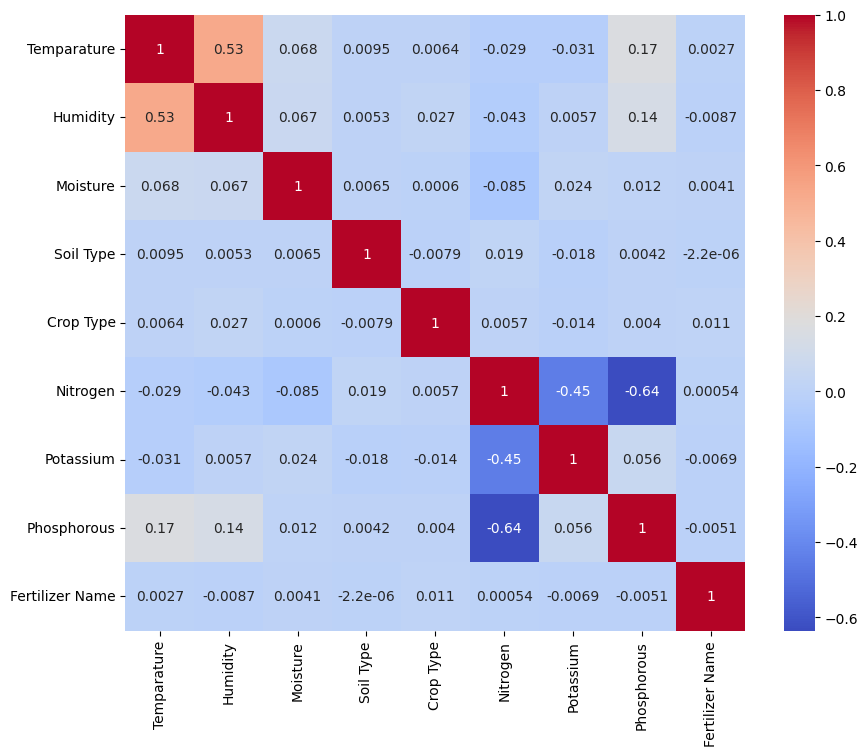

In [6]:
import seaborn as sns

corr_matrix = df.corr(numeric_only=True)  # or use numeric_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()


In [7]:
print(df.columns.tolist())

['Temparature', 'Humidity', 'Moisture', 'Soil Type', 'Crop Type', 'Nitrogen', 'Potassium', 'Phosphorous', 'Fertilizer Name']


In [8]:
# import modified dataset
# split into features(x) and target(y)
X = df.drop('Moisture',axis=1)
Y = df['Moisture']

numerical_cols = ['Temparature', 'Humidity', 'Nitrogen', 'Potassium', 'Phosphorous']  # Removed 'Moisture'
categorical_cols = ['Soil Type', 'Crop Type', 'Fertilizer Name']

# split data in traiining and testing sets for x and y both
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.2,random_state=42)
print(X_train.shape,X_test.shape,Y_train.shape,Y_test.shape)

print("Features in X_train:", X_train.columns.tolist())

missing_num = [col for col in numerical_cols if col not in X_train.columns]
missing_cat = [col for col in categorical_cols if col not in X_train.columns]

if missing_num or missing_cat:
    print("Warning: The following columns are missing from X_train:")
    print("Numerical:", missing_num)
    print("Categorical:", missing_cat)
    print("Available columns:", X_train.columns.tolist())
    raise ValueError("Column mismatch detected")

(6400, 8) (1600, 8) (6400,) (1600,)
Features in X_train: ['Temparature', 'Humidity', 'Soil Type', 'Crop Type', 'Nitrogen', 'Potassium', 'Phosphorous', 'Fertilizer Name']


Mean Absolute Error : 10.25920152889858
Mean Squared Error : 157.61019142545408
Root Mean Squared Error : 12.554289761888327
R-squared : 0.00385392449313382


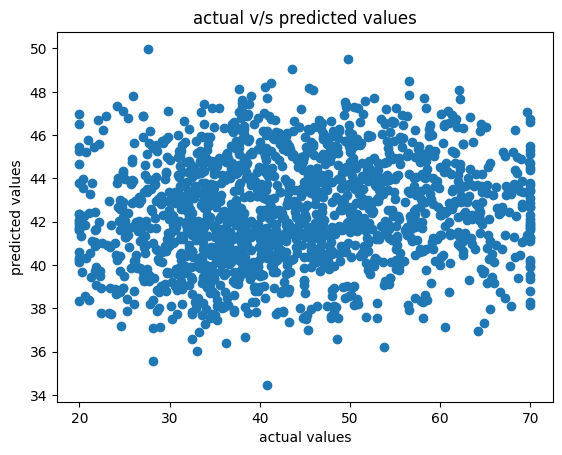

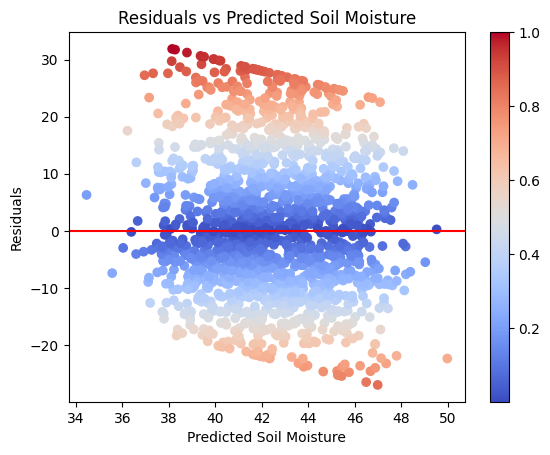

In [9]:
# support vector machine
# fit() do not accept strings --> to handle mixed data types
#pipeline + col. transformer + oneHotEncoder

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR

preprocessor = ColumnTransformer(
    transformers=[
        ('num',StandardScaler(),numerical_cols),
        ('cat',OneHotEncoder(handle_unknown='ignore'),categorical_cols)
    ]
)
svm = SVR(kernel = 'linear')

pipeline = Pipeline([
    ('preprocessor',preprocessor),
    ('regressor',svm)
])


pipeline.fit(X_train,Y_train)

Y_pred = pipeline.predict(X_test)

mae = mean_absolute_error(Y_test,Y_pred)
mse = mean_squared_error(Y_test,Y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(Y_test,Y_pred)

# evaluation metrics
print('Mean Absolute Error :',mae)
print('Mean Squared Error :',mse)
print('Root Mean Squared Error :',rmse)
print('R-squared :',r2)

err = ["Support Vector Mechanism",mae,mse,rmse,r2]
eval_metrics[1] = err

plt.scatter(Y_test.values,Y_pred)
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.title('actual v/s predicted values')
plt.show()

# residuals plotted now
residuals = Y_test.values - Y_pred
cmap = plt.cm.coolwarm
norm = plt.Normalize(vmin=0, vmax=np.abs(residuals).max())
plt.scatter(Y_pred, residuals, c=norm(np.abs(residuals)), cmap=cmap)
plt.xlabel('Predicted Soil Moisture')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Soil Moisture')
plt.axhline(y=0, color='r', linestyle='-') #horizontal line at y=0
plt.colorbar() #colorbar to show shading scale
plt.show()

In [10]:
 # gradient boosting regression
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor(n_estimators=100,learning_rate=0.1,max_depth=3,random_state=42)
gb.fit(X_train,Y_train)

Y_pred = gb.predict(X_test)

mae = mean_absolute_error(Y_test,Y_pred)
mse = mean_squared_error(Y_test,Y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(Y_test,Y_pred)
err = ["Gradient Boosting Regression",mae,mse,rmse,r2]
eval_metrics[2]=err

print("Mean Absolute Error :",mae)
print("Mean Squared Error :",mse)
print("Root Mean Squared Error :",rmse)
print("R-squared :",r2)

Mean Absolute Error : 9.923449588090259
Mean Squared Error : 145.91300438577352
Root Mean Squared Error : 12.07944553304387
R-squared : 0.07778383256991395


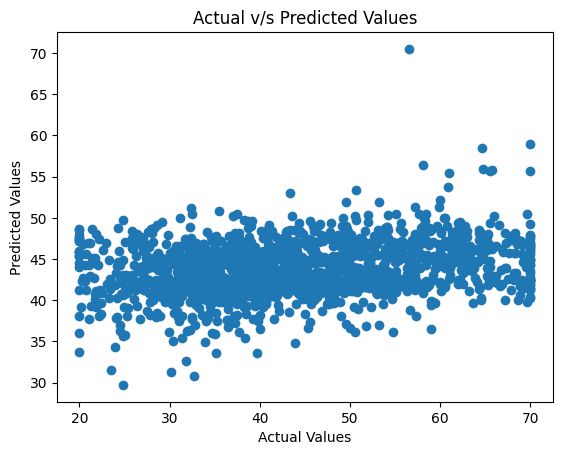

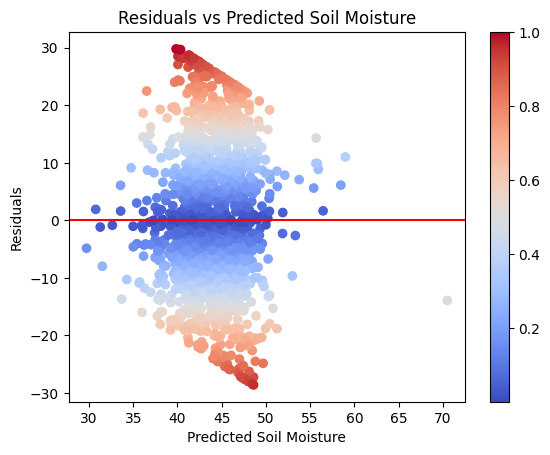

In [11]:
plt.scatter(Y_test.values,Y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual v/s Predicted Values')
plt.show()

residuals = Y_test.values - Y_pred
cmap = plt.cm.coolwarm
norm = plt.Normalize(vmin=0, vmax=np.abs(residuals).max())
plt.scatter(Y_pred, residuals, c=norm(np.abs(residuals)), cmap=cmap)
plt.xlabel('Predicted Soil Moisture')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Soil Moisture')
plt.axhline(y=0, color='r', linestyle='-') # add a horizontal line at y=0
plt.colorbar() # add a colorbar to show shading scale
plt.show()

In [12]:
# Random forest regression
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, Y_train)

Y_pred = rf_model.predict(X_test)
mae = mean_absolute_error(Y_test, Y_pred)
mse = mean_squared_error(Y_test, Y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(Y_test, Y_pred)

err=["Random Forest Regression",mae,mse,rmse,r2]
eval_metrics[3]=err

print('Mean Absolute Error :', mae)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('R-squared:', r2)

Mean Absolute Error : 9.8732859375
Mean Squared Error: 149.85077000636878
Root Mean Squared Error: 12.241354908929353
R-squared: 0.052895912989681104


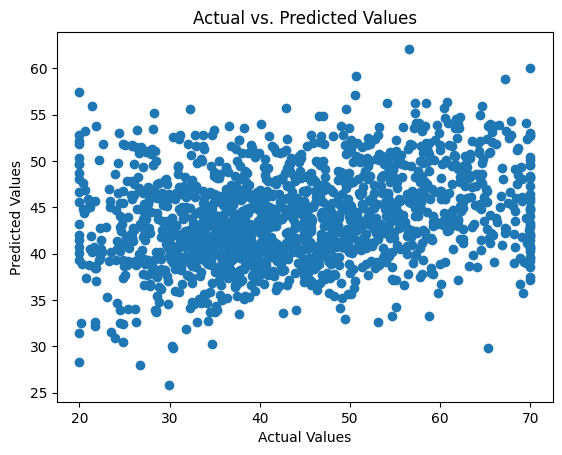

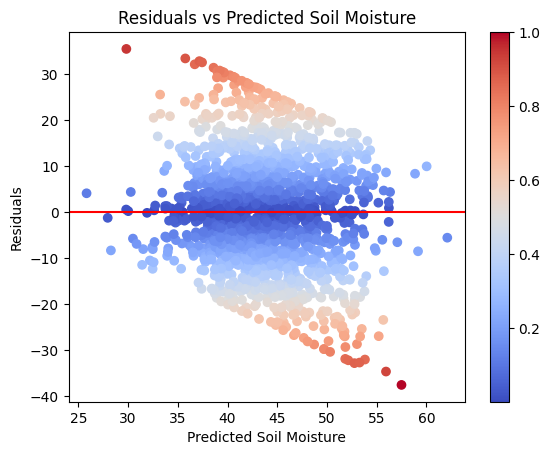

In [13]:
plt.scatter(Y_test.values, Y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.show()


# Plot the residuals
residuals = Y_test.values - Y_pred
cmap = plt.cm.coolwarm
norm = plt.Normalize(vmin=0, vmax=np.abs(residuals).max())
plt.scatter(Y_pred, residuals, c=norm(np.abs(residuals)), cmap=cmap)
plt.xlabel('Predicted Soil Moisture')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Soil Moisture')
plt.axhline(y=0, color='r', linestyle='-') # add a horizontal line at y=0
plt.colorbar() # add a colorbar to show shading scale
plt.show()

In [15]:
#feed forward neural network
print("TensorFlow version:", tf.__version__)
print("Keras version:", tf.keras.__version__)

from sklearn.preprocessing import StandardScaler
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

adam = Adam(learning_rate=1e-6, decay=1e-9)

# scale only the input features(X)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = Sequential([
    Dense(32, activation='relu', input_dim=X_train.shape[1]),
    Dense(16, activation='relu'),
    Dense(1, activation='linear')  # linear activation for regression
])

model.compile(loss='mse', optimizer=adam)

# early stopping for overfitting avoidation
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=50, 
    restore_best_weights=True
)
reduce_LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=20)

# Train the model
history = model.fit(
    X_train_scaled, 
    Y_train,  # use og Y_train (un-scaled)
    epochs=1000, # 10K used previously
    batch_size=16,
    validation_data=(X_test_scaled, Y_test),  # use og Y_test
    callbacks=[early_stop,reduce_LR],
    verbose=1
)

TensorFlow version: 2.20.0-dev20250606
Keras version: 3.10.0.dev2025061003
Epoch 1/1000


C:\Users\manoj\AppData\Roaming\Python\Python313\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
C:\Users\manoj\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 2061.9834 - val_loss: 2075.3018 - learning_rate: 1.0000e-06
Epoch 2/1000
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2061.2732 - val_loss: 2074.5945 - learning_rate: 1.0000e-06
Epoch 3/1000
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2060.5671 - val_loss: 2073.8909 - learning_rate: 1.0000e-06
Epoch 4/1000
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2059.8569 - val_loss: 2073.1868 - learning_rate: 1.0000e-06
Epoch 5/1000
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2059.1487 - val_loss: 2072.4814 - learning_rate: 1.0000e-06
Epoch 6/1000
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2058.4402 - val_loss: 2071.7766 - learning_rate: 1.0000e-06
Epoch 7/1000
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2057.7297 - val_loss: 2071.0713 - learning_rate: 1.0000e-06
Epoch 8/1000
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2057.0193 - val_loss: 2070.3660 - learning_rate: 1.0000e-06
Epoch 9/1000
400/400 ━━━━━━━━━━━━━━━━

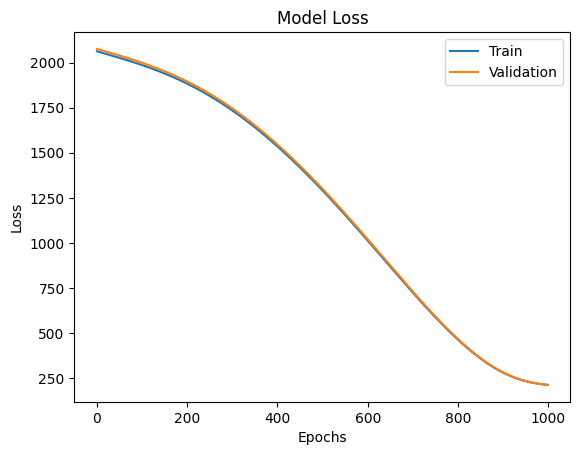

In [16]:
history.params
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [19]:
score = model.evaluate(X_test_scaled, Y_test, verbose=0)
print('Test loss:', score)
Y_pred = model.predict(X_test_scaled)
# print('Predictions:', predictions)

mae = mean_absolute_error(Y_test, Y_pred)
mse = mean_squared_error(Y_test, Y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(Y_test, Y_pred)

err=["Feedforward Neural Network",mae,mse,rmse,r2]
eval_metrics[4]=err

# Print the evaluation metrics
print('Mean Absolute Error :', mae)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('R-squared:', r2)

Test loss: 213.4072265625
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Mean Absolute Error : 11.937018228864671
Mean Squared Error: 213.40721871976746
Root Mean Squared Error: 14.608463941146155
R-squared: -0.34880087061552345


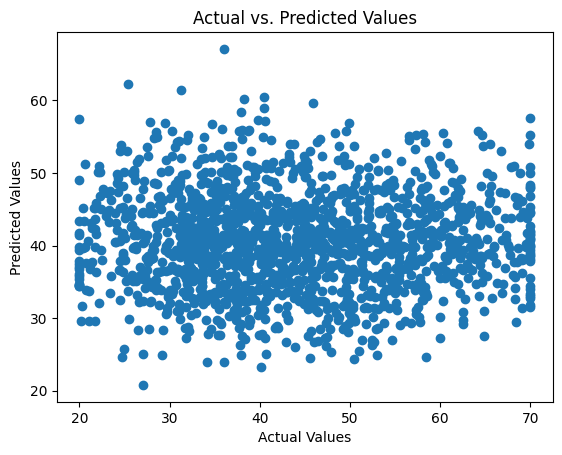

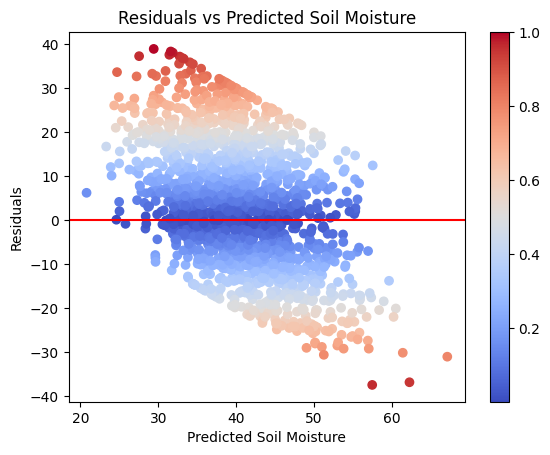

In [22]:
Y_pred = Y_pred.ravel()

plt.scatter(Y_test, Y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.show()

residuals = Y_test.values.ravel() - Y_pred.ravel()

cmap = plt.cm.coolwarm
norm = plt.Normalize(vmin=0, vmax=np.abs(residuals).max())
plt.scatter(Y_pred, residuals, c=norm(np.abs(residuals)), cmap=cmap)
plt.xlabel('Predicted Soil Moisture')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Soil Moisture')
plt.axhline(y=0, color='r', linestyle='-') #horizontal line at y=0
plt.colorbar() #colorbar to show shading scale
plt.show()

In [25]:
from tabulate import tabulate
print(tabulate(eval_metrics,headers="firstrow"))

Model                              MAE      MSE     RMSE           R2
----------------------------  --------  -------  -------  -----------
Support Vector Mechanism      10.2592   157.61   12.5543   0.00385392
Gradient Boosting Regression   9.92345  145.913  12.0794   0.0777838
Random Forest Regression       9.87329  149.851  12.2414   0.0528959
Feedforward Neural Network    11.937    213.407  14.6085  -0.348801
